In [28]:
import pandas as pd
from datetime import datetime
import calendar

In [29]:
df = pd.read_csv("https://raw.githubusercontent.com/NUS-BACT/datasets/master/hdb-resale-flat-prices.csv")

# Data Cleaning

In [30]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

### Splitting "month" column to "month" and "year"

In [31]:
# Rename "month" to "year_month"
df.rename(columns={'month': 'year_month'}, inplace=True)

# Split "year_month" to "year" and "month"
df[["year","month"]] = df["year_month"].str.split("-",expand=True)

# Change "month" from str to int
df['month']= df['month'].astype("int")

# Change "month" values from numericals to abb month strings
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

### Transform "remaining_lease" to "remaining_lease_clean" column from str to int

In [32]:
# Split 'remaining_lease' to 'remaining_year' and 'remaining_month' 
df[['remaining_year','remaining_month']] = df['remaining_lease'].str.split(" years", expand=True)

# Clean up 'remaining_month' column from blanks and unnecessary strings
df['remaining_month'] = df['remaining_month'].replace({' ':'','months':'', 'month':''}, regex=True)

# Replace blank with 0
df['remaining_month'] = df['remaining_month'].replace({'':'0'}, regex=True)

# Transfrom 'remaining_month' to int
df[['remaining_year','remaining_month']] = df[['remaining_year','remaining_month']].astype('int')

# Divide column by 12 
df['remaining_month'] = df['remaining_month'].apply(lambda x: round(x/12,1))

# Add 'remaining_year' and 'remaining_month' together
df['remaining_lease_clean'] = df['remaining_year'] + df['remaining_month']

# Drop unnecessary columns
df = df.drop(columns=['remaining_year', 'remaining_month', 'remaining_lease', 'year_month', 'street_name', 'block', 'lease_commence_date', 'year', 'month'])

# ls = []
# for type in df['flat_type']:
#     if type not in list:
#         ls.append(type)
# print(ls)

df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,remaining_lease_clean
0,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,232000.0,61.3
1,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,250000.0,60.6
2,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,262000.0,62.4
3,ANG MO KIO,3 ROOM,04 TO 06,68.0,New Generation,265000.0,62.1
4,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,265000.0,62.4


In [33]:
# imports

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm
import matplotlib.pyplot as plt

Train-Test Split

In [34]:
y = df["resale_price"]
x = df.drop(columns=["resale_price"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)


Feature encoding

In [35]:
categorical_va = []

for col in df.columns:
    if df[col].dtype == "object":
        categorical_va.append(col)

print("categorical variables are ", categorical_va)

enc_lr = OneHotEncoder(drop = "first", sparse = False, handle_unknown="ignore")
transformer_lr = ColumnTransformer([("categorical", enc_lr, categorical_va)], remainder="passthrough")
transformer_lr.fit(x_train)

x_train_encoded_lr = pd.DataFrame(transformer_lr.transform(x_train), columns = transformer_lr.get_feature_names_out())
x_test_encoded_lr = pd.DataFrame(transformer_lr.transform(x_test), columns = transformer_lr.get_feature_names_out())


categorical variables are  ['town', 'flat_type', 'storey_range', 'flat_model']


Linear regression

In [36]:
lr = LinearRegression()
lr.fit(x_train_encoded_lr, y_train)

lr.predict(x_train_encoded_lr)

def get_results(model, x, y):
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    print(f"R2: {r2}")
    print(f"MSE: {mse}")
    print(f"RMSE: {mse**0.5}")
    print(f"MAE: {mae}")

get_results(lr, x_test_encoded_lr, y_test)

R2: 0.81594322461061
MSE: 4975349908.485722
RMSE: 70536.16029020662
MAE: 55803.198585415215


In [37]:
ols = sm.OLS(y_train.reset_index(drop=True), sm.add_constant(x_train_encoded_lr))
ols_res = ols.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     7047.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:52:42   Log-Likelihood:            -1.3639e+06
No. Observations:              108454   AIC:                         2.728e+06
Df Residuals:                  108385   BIC:                         2.729e+06
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

Decision tree

In [13]:
enc = OneHotEncoder(sparse = False, handle_unknown="ignore")
transformer_tree = ColumnTransformer([
    ("categorical", enc, categorical_va)
], remainder= "passthrough")

transformer_tree.fit(x_train)

x_train_encoded_tree = pd.DataFrame(transformer_tree.transform(x_train), columns = transformer_tree.get_feature_names_out())
x_test_encoded_tree = pd.DataFrame(transformer_tree.transform(x_test), columns = transformer_tree.get_feature_names_out())

dt = DecisionTreeRegressor(random_state = 0)
dt.fit(x_train_encoded_tree, y_train)

get_results(dt, x_test_encoded_tree, y_test)


R2: 0.9235168758237349
MSE: 2067461543.1354465
RMSE: 45469.347291724414
MAE: 31066.175345683307


In [17]:


def plot_tree(model, x):
    fig = plt.figure(figsize=(25, 20))
    tree.plot_tree(model, feature_names=x.columns,
    class_names = ['0', '1'], filled = True, proportion=True)
def plot_importance(model, x):
    importances = pd.Series(data=model.feature_importances_, index = list(x.columns))
    importances_sorted = importances.sort_values()
    importances_sorted = importances_sorted[-10:]
    plt.figure(figsize = (10, 6))
    importances_sorted.plot(kind = 'barh', color = 'blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance")
    plt.show()



In [14]:
plot_tree(dt, x_train_encoded_tree)

KeyboardInterrupt: 

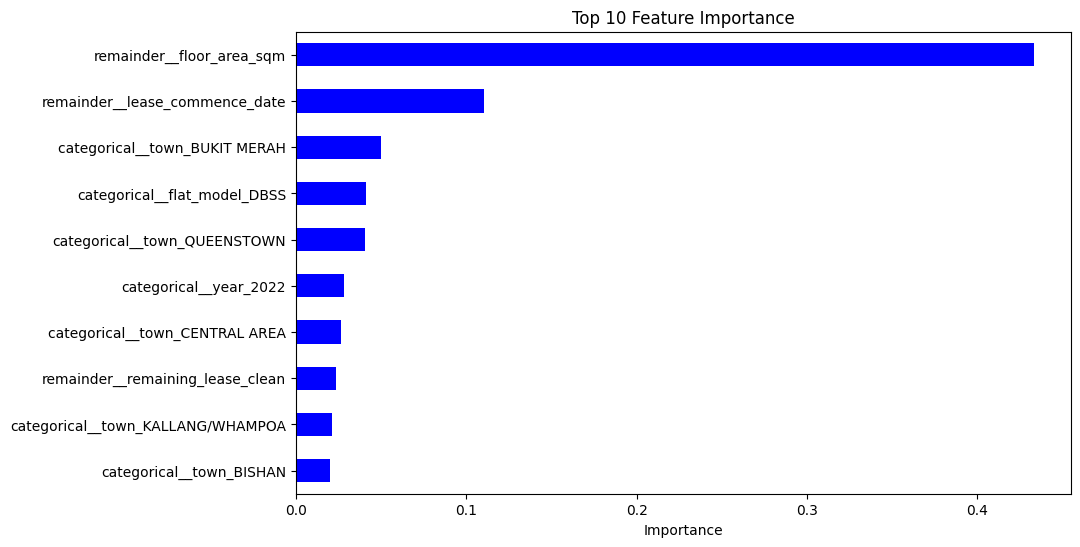

In [18]:
plot_importance(dt, x_train_encoded_tree)

Random forest

In [20]:
rf = RandomForestRegressor(random_state=0, max_depth=5)

rf.fit(x_train_encoded_tree, y_train)

get_results(rf, x_test_encoded_tree, y_test)

R2: 0.6420292958183269
MSE: 9676522401.975777
RMSE: 98369.31636427986
MAE: 71121.3348421442


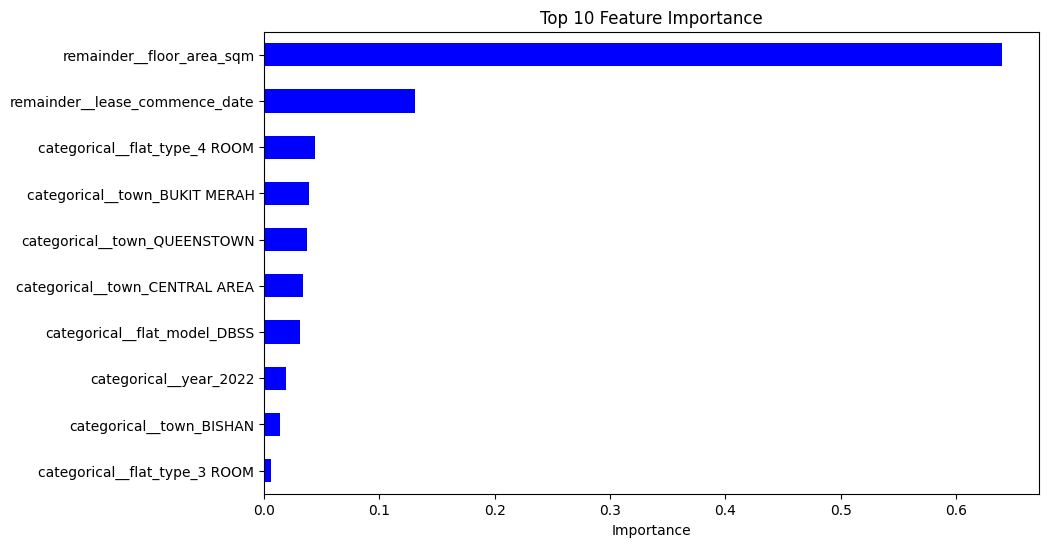

In [21]:
plot_importance(rf, x_train_encoded_tree)

Cross validation

In [23]:
dt_pipe = Pipeline([
    ("feature_preprocessing", transformer_tree),  # perform the encoding within the pipeline itself
    ("decision_tree", DecisionTreeRegressor(random_state=0))
])

cross_validate(dt_pipe, x_train, y_train, cv=10, return_train_score=True)

{'fit_time': array([0.92397094, 0.88565779, 0.88413215, 0.8909421 , 0.88748288,
        0.89296317, 0.89700723, 0.88894296, 0.9015739 , 0.91242719]),
 'score_time': array([0.0163281 , 0.01644421, 0.01723385, 0.01630092, 0.01483583,
        0.01634693, 0.0152359 , 0.01559901, 0.01609111, 0.01615477]),
 'test_score': array([0.92254908, 0.91912749, 0.92211026, 0.92143175, 0.92076703,
        0.91823379, 0.92503267, 0.92202118, 0.9199043 , 0.91627772]),
 'train_score': array([0.99928962, 0.99928594, 0.99930391, 0.99931046, 0.99931121,
        0.99930202, 0.99927381, 0.99929397, 0.99929461, 0.9993016 ])}

In [24]:
def get_CV_results(model, X, y, cv=10):
    scores = cross_validate(model, X, y, cv=cv, return_train_score=True)
    print(f"Mean Test Score: {scores['test_score'].mean()}")
    print("\n")

    display(pd.DataFrame(scores)) 

get_CV_results(dt_pipe, x_train, y_train)

Mean Test Score: 0.9207455271109939




,fit_time,score_time,test_score,train_score
0,0.910868,0.016288,0.922549,0.999290
1,0.887729,0.015036,0.919127,0.999286
2,0.888987,0.015748,0.922110,0.999304
3,0.897257,0.016166,0.921432,0.999310
4,0.923934,0.016111,0.920767,0.999311
5,0.889202,0.018485,0.918234,0.999302
6,0.900065,0.017388,0.925033,0.999274
7,0.893101,0.016273,0.922021,0.999294
8,0.906607,0.016208,0.919904,0.999295
9,0.880534,0.016075,0.916278,0.999302


Hyperparameter

In [25]:
# create pipeline
dt_pipe = Pipeline([
      ("feature_preprocessing", transformer_tree),  # perform the encoding within the pipeline itself
      ("decision_tree", DecisionTreeRegressor(random_state=0))
    ])

# state params to test (grid)
params = {"decision_tree__max_depth": [None, 3, 4, 5, 6], 
          "decision_tree__min_samples_leaf": np.arange(2, 11, 1)}

# create GridSearchCV object
dt_gs = GridSearchCV(estimator = dt_pipe, 
                    param_grid = params, cv = 10,
                    return_train_score = True)

# fit GridSearchCV object onto training data
dt_gs.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['town',
                                                                          'flat_type',
                                                                          'storey_range',
                                                                          'flat_model',
                                                                          'year',
                                                                          'month'])])),
                                       ('decision_tree',
                                        DecisionTreeRegressor(random_state=0))]),
             param_grid={'decision_tree__max_depth': [None, 3, 4, 5, 6],
                         'decision_tree__min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True)

In [27]:
def report_GridSearchCV_results(grid):
    print("Best combination of hyperparams:\n", grid.best_params_, "\n")
    print("Best mean_test_score score:\n", grid.best_score_, "\n")
    
    scores = []
    for i in range(grid.n_splits_):
        scores.append(grid.cv_results_['split{}_test_score'.format(i)][grid.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(grid.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in grid.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))

report_GridSearchCV_results(dt_gs)

get_results(dt_gs, x_test, y_test)

Best combination of hyperparams:
 {'decision_tree__max_depth': None, 'decision_tree__min_samples_leaf': 5} 

Best mean_test_score score:
 0.9355956555641731 

Score by fold for best estimator:
 [0.9392229709166586, 0.9340445792753076, 0.9349679952864998, 0.9368585333853576, 0.937354967102652, 0.9346759139818652, 0.9359266962107584, 0.9372965858172336, 0.9351199305084253, 0.9304883831569715] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_decision_tree__max_depth,param_decision_tree__min_samples_leaf
rank_test_score,,,
1,0.935596,None,5
2,0.935591,None,4
3,0.935580,None,6
4,0.935277,None,7
5,0.934899,None,8


R2: 0.9359340535315539
MSE: 1731805309.6632097
RMSE: 41614.964972509704
MAE: 28336.729091393954
